# Implementing an autoregressive Seq2Seq model using GRU architecture

### About this notebook

This notebook was created as a deliverable for the group project under 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Group 17 - Cohort 01

## Define device for Torch - preferred CUDA for accelerated computation

In [1]:
# Matplotlib
import torch

# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


## Import train and test dataset

### Define load dataset function

In [2]:
import pandas as pd

def load_dataset(train_path, test_path):
    # Load and drop date column
    train_df = pd.read_csv(train_path, parse_dates=['date']).drop(columns=['date'])
    test_df = pd.read_csv(test_path, parse_dates=['date']).drop(columns=['date'])

    # Normalize using training statistics
    stats = train_df.describe().transpose()

    def normalize(df):
        return (df - stats["mean"]) / stats["std"]

    train_norm = normalize(train_df)
    test_norm = normalize(test_df)

    return train_norm, test_norm, stats

### Load train and test dataset

In [ ]:
# Load dataset from file
train_file_path = '../dataset/train/DailyDelhiClimateTrain.csv'
test_file_path = '../dataset/test/DailyDelhiClimateTest.csv'
train_data, test_data, stats = load_dataset(train_file_path, test_file_path)

In [4]:
train_data[:5]

,meantemp,humidity,wind_speed,meanpressure
0,-2.108778,1.414955,-1.491189,0.025313
1,-2.462611,1.862191,-0.837909,0.037149
2,-2.494366,1.564034,-0.475464,0.041958
3,-2.290231,0.629806,-1.220816,0.033635
4,-2.653137,1.554095,-0.680070,0.029936


In [5]:
# number of samples in train dataset
len(train_data)

1462

## Define Pytorch Dataset and Dataloader objects

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

### Dataset object

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, n_inputs, n_outputs):
        self.dataframe = dataframe
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.inputs = []
        self.outputs = []
        self.define_samples()

    def define_samples(self):
        data_array = self.dataframe.values
        for i in range(len(data_array) - self.n_inputs - self.n_outputs):
            input_seq = data_array[i:i+self.n_inputs, :]         # Sequence length of 30, incl all features
            output_seq = data_array[i+self.n_inputs:i+self.n_inputs+self.n_outputs, :]  # Sequence length of 7, incl all features
            self.inputs.append(input_seq)
            self.outputs.append(output_seq)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)  # Shape: (n_inputs, 4)
        y = torch.tensor(self.outputs[idx], dtype=torch.float32) # Shape: (n_outputs,)
        return x, y

In [8]:
n_inputs = 30
n_outputs = 7
train_dataset = CustomDataset(train_data, n_inputs, n_outputs)
test_dataset = CustomDataset(test_data, n_inputs, n_outputs)

In [9]:
train_dataset[0]

(tensor([[-2.1088e+00,  1.4150e+00, -1.4912e+00,  2.5313e-02],
         [-2.4626e+00,  1.8622e+00, -8.3791e-01,  3.7149e-02],
         [-2.4944e+00,  1.5640e+00, -4.7546e-01,  4.1958e-02],
         [-2.2902e+00,  6.2981e-01, -1.2208e+00,  3.3635e-02],
         [-2.6531e+00,  1.5541e+00, -6.8007e-01,  2.9936e-02],
         [-2.5170e+00,  1.3136e+00, -1.1667e+00,  3.8259e-02],
         [-2.5170e+00,  1.0631e+00, -1.1009e-01,  4.9356e-02],
         [-2.2643e+00,  1.7547e-01,  7.4677e-02,  4.2222e-02],
         [-1.5644e+00, -5.6779e-01,  1.2491e+00,  3.2710e-02],
         [-1.9727e+00,  7.3245e-02,  1.3105e-01,  2.5313e-02],
         [-1.3311e+00, -5.6566e-01,  8.2629e-01,  2.7955e-02],
         [-1.5644e+00,  7.8882e-01,  1.4088e+00,  2.4784e-02],
         [-1.3149e+00,  8.5839e-01, -4.7546e-01,  1.2366e-02],
         [-1.7232e+00,  1.6336e+00, -1.3560e+00,  2.2538e-02],
         [-1.4672e+00,  6.6104e-01, -1.3753e+00,  2.6369e-02],
         [-1.5871e+00,  1.5442e+00, -1.4912e+00,  3.086

### Dataloader Object

In [10]:
# Define batch size
batch_size = 128

# Random number generator (for reproducibility)
generator = torch.Generator()  # Defaults to CPU, which DataLoader expects

# Create DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=generator
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Important: don't shuffle test data
    generator=generator
)

In [11]:
# Visualize a sample
sample = next(iter(train_dataloader))
input_sample, output_sample = sample
print("Input shape:", input_sample.shape)
print("Output shape:", output_sample.shape)


Input shape: torch.Size([128, 30, 4])
Output shape: torch.Size([128, 7, 4])


In [12]:
len(train_dataloader)

12

## Define Model Architecture

### Our Encoder Model

The EncoderGRU below processes input sequences using a Gated Recurrent Unit (GRU) network. It is designed to capture temporal dependencies and compress the full input sequence into a single hidden state that summarizes the important patterns and dynamics over time.

Unlike the LSTM, the GRU architecture uses a simpler gating mechanism, making it computationally more efficient while still effectively learning long-term dependencies. This encoder takes in multivariate weather data (e.g., temperature, humidity, wind speed, pressure) and returns only the final hidden state — a compact representation of the entire sequence.

This hidden state is then used to initialize the decoder in the sequence-to-sequence architecture, enabling the model to generate future predictions based on the learned context of the input sequence.

#### Define Encoder class

In [13]:
# Numpy
import numpy as np
# Torch
import torch
import torch.nn as nn

In [14]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1, dropout = 0.0):
        super(EncoderGRU, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size,
                          num_layers = num_layers,
                          dropout = dropout if num_layers > 1 else 0.0,
                          batch_first = False)

    def forward(self, input_seq):
        # input_seq: (seq_len, batch_size, input_size)
        output, hidden = self.gru(input_seq)
        return hidden

In [15]:
# Defining our EncoderRNN model
hidden_size = 64
encoder_model = EncoderGRU(4, hidden_size)
print(encoder_model)

EncoderGRU(
  (gru): GRU(4, 64)
)


#### Testing Encoder model

In [18]:
# Grab one batch from the train dataloader
inputs, _ = next(iter(train_dataloader))  # inputs shape: (batch_size, seq_len, input_size)

# Rearrange for GRU: (seq_len, batch_size, input_size)
inputs = inputs.permute(1, 0, 2)  # (seq_len, batch_size, input_size)

print("Input shape to encoder:", inputs.shape)  # Should be (seq_len, batch_size, 4)

# Pass through encoder
encoder_out = encoder_model(inputs)

print("Encoder output (last hidden state) shape:", encoder_out.shape)  # (1, batch_size, hidden_size)
print("Sample vector:", encoder_out[0])

Input shape to encoder: torch.Size([30, 128, 4])
Encoder output (last hidden state) shape: torch.Size([1, 128, 64])
Sample vector: tensor([[-0.0613,  0.0005,  0.0925,  ..., -0.0968, -0.1059,  0.0902],
        [ 0.0585,  0.0454,  0.2465,  ..., -0.1023, -0.1212,  0.1075],
        [-0.0395, -0.0707,  0.0620,  ..., -0.0628,  0.1722, -0.0149],
        ...,
        [-0.0316, -0.0870,  0.1575,  ..., -0.1427,  0.0827, -0.0223],
        [-0.1055, -0.0447,  0.1526,  ..., -0.1378, -0.0367,  0.0406],
        [-0.0386, -0.0954,  0.0858,  ..., -0.1199,  0.1921, -0.0848]],
       grad_fn=<SelectBackward0>)


### Our Decoder Model

The DecoderGRU class is a PyTorch module designed to serve as the decoder in a sequence-to-sequence architecture. It processes input sequences using a Gated Recurrent Unit (GRU), which efficiently models temporal dependencies with a simpler structure than LSTM.

At each decoding step, the model takes in a multivariate feature vector (e.g., temperature, humidity, wind speed, pressure) and a hidden state from the encoder. It produces the next predicted output through a linear layer that maps the GRU’s hidden state to the desired feature space.

The decoder supports teacher forcing during training, using either the ground-truth features or its own previous prediction as input for the next step. This design enables it to generate multi-step forecasts in an autoregressive manner while retaining the context learned by the encoder.

#### Define Decoder class

In [23]:
class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, feature_size, num_layers = 1, dropout = 0.0):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.feature_size = feature_size # 4 features

        self.gru = nn.GRU(input_size=feature_size,
                          hidden_size=hidden_size,
                          dropout = dropout if num_layers > 1 else 0.0,
                          batch_first=False)

        self.linear = nn.Linear(hidden_size, feature_size)

    def forward(self, x, hidden, output_length, target=None):
        outputs = []
        decoder_input = x  # shape: (1, batch_size, 4)

        for i in range(output_length):
            # One step forward through GRU
            decoder_output, hidden = self.gru(decoder_input, hidden)
            decoder_output = self.linear(decoder_output)  # shape: (1, batch_size, 4)
            outputs.append(decoder_output)

            if target is not None:
                # Teacher forcing: use actual target
                decoder_input = target[i].unsqueeze(0)  # shape: (1, batch_size, 4)
            else:
                # Auto-regressive: use own prediction
                decoder_input = decoder_output.detach()  # detach to prevent gradient flow

        return torch.cat(outputs, dim=0)  # shape: (output_length, batch_size, 1)

In [24]:
# Defining our DecoderRNN model
decoder_model = DecoderGRU(hidden_size = hidden_size, feature_size = 4)
print(decoder_model)

DecoderGRU(
  (gru): GRU(4, 64)
  (linear): Linear(in_features=64, out_features=4, bias=True)
)


#### Testing Decoder model

In [25]:
# Testing our DecoderRNN model

# Get a batch from dataloader
inputs, _ = next(iter(train_dataloader))  # inputs: (batch_size, seq_length, input_size)

# Permute for encoder: (seq_length, batch_size, input_size)
encoder_input = inputs.permute(1, 0, 2)

# Pass through encoder
encoder_hidden = encoder_model(encoder_input)  # shape: (1, batch_size, hidden_size)

# Initial decoder input: zeros, shape (1, batch_size, 1)
decoder_input = torch.zeros(1, inputs.size(0), 4).to(encoder_input.device)

# Run decoder
decoder_output = decoder_model(decoder_input, encoder_hidden, n_outputs)

# Output shape: (T_out, B, 1)
print("Decoder output shape:", decoder_output.shape)

Decoder output shape: torch.Size([7, 128, 4])


### Our Seq2Seq Model

By assembling the EncoderGRU and DecoderGRU classes, the Seq2SeqGRU class implements a sequence-to-sequence model using an encoder-decoder architecture built with GRUs.

The encoder processes the entire input sequence — consisting of multiple time steps and multiple weather features — and compresses it into a final hidden state. This hidden state captures the temporal patterns and context of the input data and serves as the initial memory for the decoder.

The decoder then uses this context to generate the output sequence one timestep at a time, predicting all target features (e.g., temperature, humidity, wind speed, pressure) for each future step. During training, it can optionally use teacher forcing, feeding the ground-truth values into subsequent steps to improve convergence.

This design enables the model to make informed, multi-step forecasts of all relevant features based on learned temporal dynamics from the input sequence.

#### Define Seq2Seq class

In [26]:
class Seq2SeqGRU(nn.Module):
    def __init__(self, hidden_size, feature_size, output_size, num_layers=1):
        super(Seq2SeqGRU, self).__init__()

        self.output_length = output_size

        self.encoder = EncoderGRU(input_size=feature_size, # 4 features
                                  hidden_size=hidden_size,
                                  num_layers= num_layers)

        self.decoder = DecoderGRU(hidden_size=hidden_size,
                                  feature_size=feature_size,
                                  num_layers=num_layers)  # 4 features

    def forward(self, inputs, outputs=None):
        """
        Args:
            inputs: shape (seq_len, batch_size, input_size=4)
            outputs: optional teacher forcing target, shape (output_length, batch_size, 1)
        """
        hidden = self.encoder(inputs)  # returns (1, batch_size, hidden_size)

        # Initial decoder input: zeros (1, batch_size, 4)
        decoder_input = torch.zeros(1, inputs.shape[1], self.decoder.feature_size).to(inputs.device)

        # Pass to decoder
        output = self.decoder(decoder_input, hidden, self.output_length, outputs)
        return output  # shape: (output_length, batch_size, 1)

In [27]:
# Defining our Seq2Seq model
seq2seq_model = Seq2SeqGRU(hidden_size = hidden_size, \
                          feature_size = 4, \
                          output_size = n_outputs)
print(seq2seq_model)

Seq2SeqGRU(
  (encoder): EncoderGRU(
    (gru): GRU(4, 64)
  )
  (decoder): DecoderGRU(
    (gru): GRU(4, 64)
    (linear): Linear(in_features=64, out_features=4, bias=True)
  )
)


#### Testing seq2seq model

In [29]:
# Instantiate model
seq2seq_model = Seq2SeqGRU(hidden_size=hidden_size, feature_size = 4, output_size=n_outputs).to(device)

# Get a batch from the dataloader
inputs, outputs = next(iter(train_dataloader))  # shapes: (B, T_in, 4), (B, T_out)

inputs = inputs.to(device)
outputs = outputs.to(device)

# Permute to (seq_length, batch_size, input_size)
inputs = inputs.permute(1, 0, 2)
outputs = outputs.permute(1, 0, 2)

print("Input shape:", inputs.shape)   # (input_seq_len, batch_size, 4)
print("Target shape:", outputs.shape) # (output_seq_len, batch_size, 1)

# Forward pass
seq2seq_out = seq2seq_model(inputs, outputs)

print("Output shape:", seq2seq_out.shape)  # (output_seq_len, batch_size, 1)

Input shape: torch.Size([30, 128, 4])
Target shape: torch.Size([7, 128, 4])
Output shape: torch.Size([7, 128, 4])


## Model training

### Define function for training


In [31]:
loss_storage = []

def train(dataloader, model, num_epochs, learning_rate, device):
    # Set model to training mode
    model.train()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, targets in dataloader:
            # Move to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape to (seq_len, batch_size, input_size)
            inputs = inputs.permute(1, 0, 2)  # (T_in, B, 4)
            targets = targets.permute(1, 0, 2)  # (T_out, B, 4)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with teacher forcing
            predictions = model(inputs, targets)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(dataloader)
        loss_storage.append(avg_loss)

        # Print loss periodically
        if (epoch + 1) % 25 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

### Instantiate a model from Seq2Seq class

In [32]:
# Hyperparameters
hidden_size = 64
feature_size = 4
num_epochs = 1051
num_layers = 1
dropout_rate = 0.1

seq2seq_model = Seq2SeqGRU(hidden_size=hidden_size,
                           feature_size = feature_size,
                           output_size=n_outputs,
                           num_layers=num_layers).to(device)

In [33]:
seq2seq_model

Seq2SeqGRU(
  (encoder): EncoderGRU(
    (gru): GRU(4, 64)
  )
  (decoder): DecoderGRU(
    (gru): GRU(4, 64)
    (linear): Linear(in_features=64, out_features=4, bias=True)
  )
)

### Train model

In [34]:
# Run training for warm-up
%timeit -r 1 -n 1 train( dataloader=train_dataloader, model=seq2seq_model, num_epochs=num_epochs, learning_rate=1e-3, device=device)

Epoch 1/1051, Avg Loss: 0.9029
Epoch 25/1051, Avg Loss: 0.5065
Epoch 50/1051, Avg Loss: 0.4256
Epoch 75/1051, Avg Loss: 0.3273
Epoch 100/1051, Avg Loss: 0.2497
Epoch 125/1051, Avg Loss: 0.2172
Epoch 150/1051, Avg Loss: 0.2046
Epoch 175/1051, Avg Loss: 0.1914
Epoch 200/1051, Avg Loss: 0.1730
Epoch 225/1051, Avg Loss: 0.1621
Epoch 250/1051, Avg Loss: 0.1614
Epoch 275/1051, Avg Loss: 0.1379
Epoch 300/1051, Avg Loss: 0.1305
Epoch 325/1051, Avg Loss: 0.1225
Epoch 350/1051, Avg Loss: 0.1154
Epoch 375/1051, Avg Loss: 0.1093
Epoch 400/1051, Avg Loss: 0.1071
Epoch 425/1051, Avg Loss: 0.0973
Epoch 450/1051, Avg Loss: 0.0940
Epoch 475/1051, Avg Loss: 0.0899
Epoch 500/1051, Avg Loss: 0.0855
Epoch 525/1051, Avg Loss: 0.0826
Epoch 550/1051, Avg Loss: 0.0769
Epoch 575/1051, Avg Loss: 0.0755
Epoch 600/1051, Avg Loss: 0.0715
Epoch 625/1051, Avg Loss: 0.0704
Epoch 650/1051, Avg Loss: 0.0659
Epoch 675/1051, Avg Loss: 0.0645
Epoch 700/1051, Avg Loss: 0.0633
Epoch 725/1051, Avg Loss: 0.0599
Epoch 750/1051,

### Save the model parameter

In [ ]:
# save model before eval
import torch
import os

model_name="seq2seq_autoregressive_GRU"

# Path to save model
model_path = os.path.join("../models_weights_storage", f'{model_name}.pth')

# Save the model's state dict
torch.save(seq2seq_model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../models_weights_storage/seq2seq_autoregressive_GRU.pth


In [37]:
loss_storage

[0.9029224663972855,
 0.7610846981406212,
 0.6231614301602045,
 0.5642748773097992,
 0.5410257006684939,
 0.537746592114369,
 0.5291583612561226,
 0.5183665206034979,
 0.5135171810785929,
 0.5133767078320185,
 0.5031907086571058,
 0.5064944426218668,
 0.5025105600555738,
 0.49772103875875473,
 0.4947575703263283,
 0.5091805905103683,
 0.49163520336151123,
 0.49731194227933884,
 0.49095237875978154,
 0.4932182307044665,
 0.4880551832417647,
 0.500492541740338,
 0.48657629763086635,
 0.6951718740165234,
 0.5064723653097948,
 0.6854418019453684,
 0.4947519525885582,
 0.48218640064199764,
 0.4779203571379185,
 0.4854293887813886,
 0.47166676074266434,
 0.47282468651731807,
 0.6862465043862661,
 0.4716090299189091,
 0.4760975018143654,
 0.47146741797526676,
 0.6711217649281025,
 0.4736982708175977,
 0.4797196375826995,
 0.46243572731812793,
 0.46175530180335045,
 0.46302864452203113,
 0.4622560751934846,
 0.4610408904651801,
 0.4586513539155324,
 0.47160330911477405,
 0.4504120983183384,
 0

## Plot loss curve during model training

### Define a function to plot the loss curve

In [38]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_storage, tick_interval=10,save_path=None):
    plt.figure(figsize=(12, 6))

    epochs = list(range(1, len(loss_storage) + 1))

    # Plot the loss
    plt.plot(
        epochs,
        loss_storage,
        color='royalblue',
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=4,
        label='Training Loss'
    )

    # Title & labels
    plt.title("Training Loss Curve", fontsize=18, fontweight='bold')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    # Set x-ticks with wider spacing
    plt.xticks(
        ticks=range(0, len(loss_storage) + 1, tick_interval),
        fontsize=12
    )
    plt.yticks(fontsize=12)

    # Grid, legend and layout
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Loss curve saved to: {save_path}")

    plt.show()



### Plot the loss curve and save the image

Loss curve saved to: seq2seq_autoregressive_LSTM_loss_training_curve.png


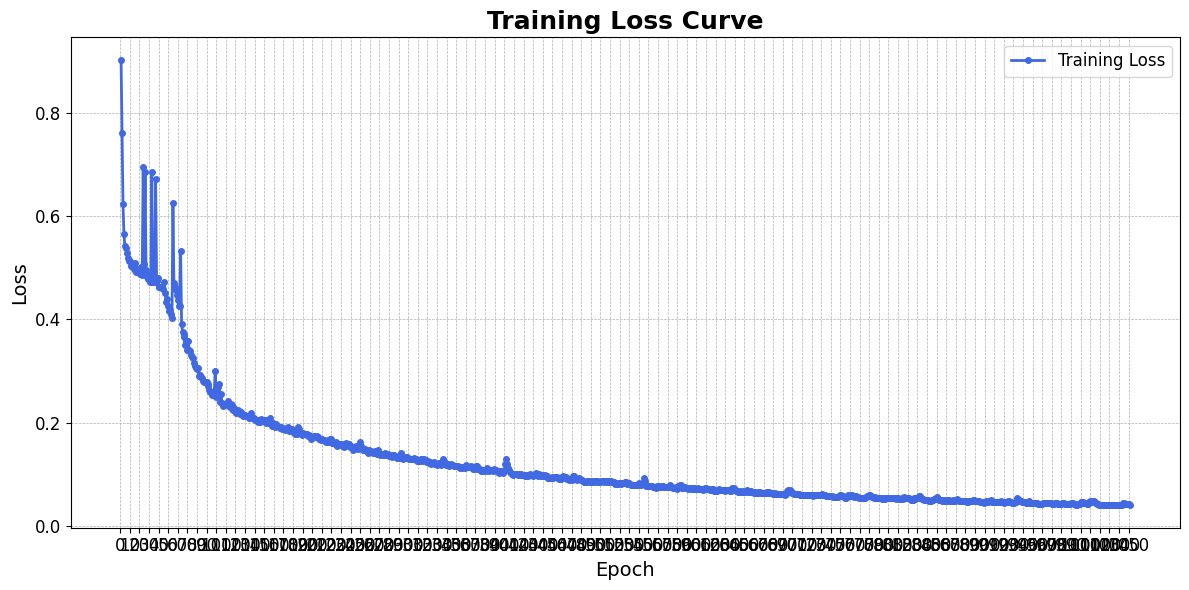

In [ ]:
save_path="../images_model_training_and_eval/seq2seq_autoregressive_GRU_loss_training_curve.png"

plot_loss_curve(loss_storage,save_path=save_path)

## Model Evaluation

### Define evaluation model function

In [40]:
def evaluate_model(model, dataloader, seed_value):
    model.eval()
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.to(device)
    outputs = outputs.to(device)

    inputs_seq = inputs.permute(1, 0, 2)
    outputs_seq = outputs.permute(1, 0, 2)

    pred = model(inputs_seq)

    true_vals = outputs_seq.cpu().numpy()[:, 0, :]
    pred_vals = pred.detach().cpu().numpy()[:, 0, :]

    print("Ground truth:\n", true_vals.T)
    print("Prediction:\n", pred_vals.T)
    print("MAE:", np.mean(np.abs(true_vals - pred_vals)))

    feature_mae = np.mean(np.abs(true_vals - pred_vals), axis=(0, 1))
    print("Feature-wise MAE:", feature_mae)

In [41]:
seed_value=187

evaluate_model(seq2seq_model,test_dataloader,seed_value)

Ground truth:
 [[-1.2752299  -1.3943083  -1.1437798  -1.3417282  -0.9247994  -0.93411076
  -1.1712726 ]
 [ 0.9080867   1.0646194   0.3442977   1.0381919   1.0034971   1.0053803
   0.53042036]
 [-0.47729036 -0.37316027 -0.82754606 -1.0846328   0.6615639   0.28450337
   0.49154565]
 [ 0.02438779  0.03548462  0.04330284  0.03674562  0.01828454  0.01723326
   0.027162  ]]
Prediction:
 [[-0.99984455 -0.9435886  -0.8964366  -0.9496924  -1.2408503  -1.1738461
  -1.1011612 ]
 [ 0.37409744  0.2804373   0.32042342  0.31891286  0.7921205   0.64430064
   0.25834158]
 [-0.3444062  -0.6141616  -0.96335477  0.18131952  0.29912668 -0.974649
  -0.36963958]
 [-0.27213556 -0.27508444 -0.12224311  0.06529632 -0.05558211  0.16858989
  -0.22016019]]
MAE: 0.3724785
Feature-wise MAE: 0.3724785


#### Define function to plot prediction versus ground truth

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def model_evaluation_and_visualizations(model, dataloader, device, stats=None, indices=[2486, 2986]):
    feature_names = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors per feature

    plt.style.use('ggplot')  # Consistent, readable plotting style
    model.eval()

    num_features = len(feature_names)
    num_samples = len(indices)

    fig, axs = plt.subplots(num_samples, num_features, figsize=(5 * num_features, 4 * num_samples))

    for row, seed in enumerate(indices):
        g = torch.Generator()
        g.manual_seed(seed)

        # Rebuild a deterministic DataLoader with shuffling
        data_iter = iter(torch.utils.data.DataLoader(
            dataloader.dataset, batch_size=32, shuffle=True, generator=g
        ))

        inputs, outputs = next(data_iter)
        inputs, outputs = inputs.to(device), outputs.to(device)

        # Permute for (seq_len, batch, feature)
        inputs_seq = inputs.permute(1, 0, 2)      # (T_in, B, F)
        outputs_seq = outputs.permute(1, 0, 2)    # (T_out, B, F)
        preds = model(inputs_seq)                # (T_out, B, F)

        b = 0  # Visualize the first sample in the batch

        # Get the data for sample b
        x = inputs_seq[:, b, :].detach().cpu().numpy()      # (T_in, F)
        y_true = outputs_seq[:, b, :].detach().cpu().numpy()  # (T_out, F)
        y_pred = preds[:, b, :].detach().cpu().numpy()        # (T_out, F)

        # Denormalize if stats are provided
        if stats is not None:
            for i, name in enumerate(feature_names):
                mean = stats.loc[name, 'mean']
                std = stats.loc[name, 'std']
                x[:, i] = x[:, i] * std + mean
                y_true[:, i] = y_true[:, i] * std + mean
                y_pred[:, i] = y_pred[:, i] * std + mean

        # Time steps
        t_input = list(range(x.shape[0]))
        t_output = [x.shape[0] + i + 1 for i in range(y_true.shape[0])]
        mse = np.mean((y_true - y_pred) ** 2)

        # Plot each feature separately
        for col in range(num_features):
            ax = axs[row, col] if num_samples > 1 else axs[col]
            feature = feature_names[col]
            color = colors[col % len(colors)]

            # Input sequence
            ax.plot(t_input, x[:, col], linestyle='--', linewidth=2, label="Input", color=color)
            # Ground truth output
            ax.scatter(t_output, y_true[:, col], label="True", color=color, marker='o', s=50, edgecolors='black', linewidth=0.5)
            # Predicted output
            ax.scatter(t_output, y_pred[:, col], label="Pred", color='black', marker='x', s=60)

            ax.set_title(f"{feature} | seed={seed} | MSE={mse:.4f}", fontsize=11)
            ax.grid(True)

            if row == num_samples - 1:
                ax.set_xlabel("Timestep")
            if col == 0:
                ax.set_ylabel("Value")
            if row == 0:
                ax.legend(loc='upper center', fontsize=8)

    plt.tight_layout()
    plt.show()



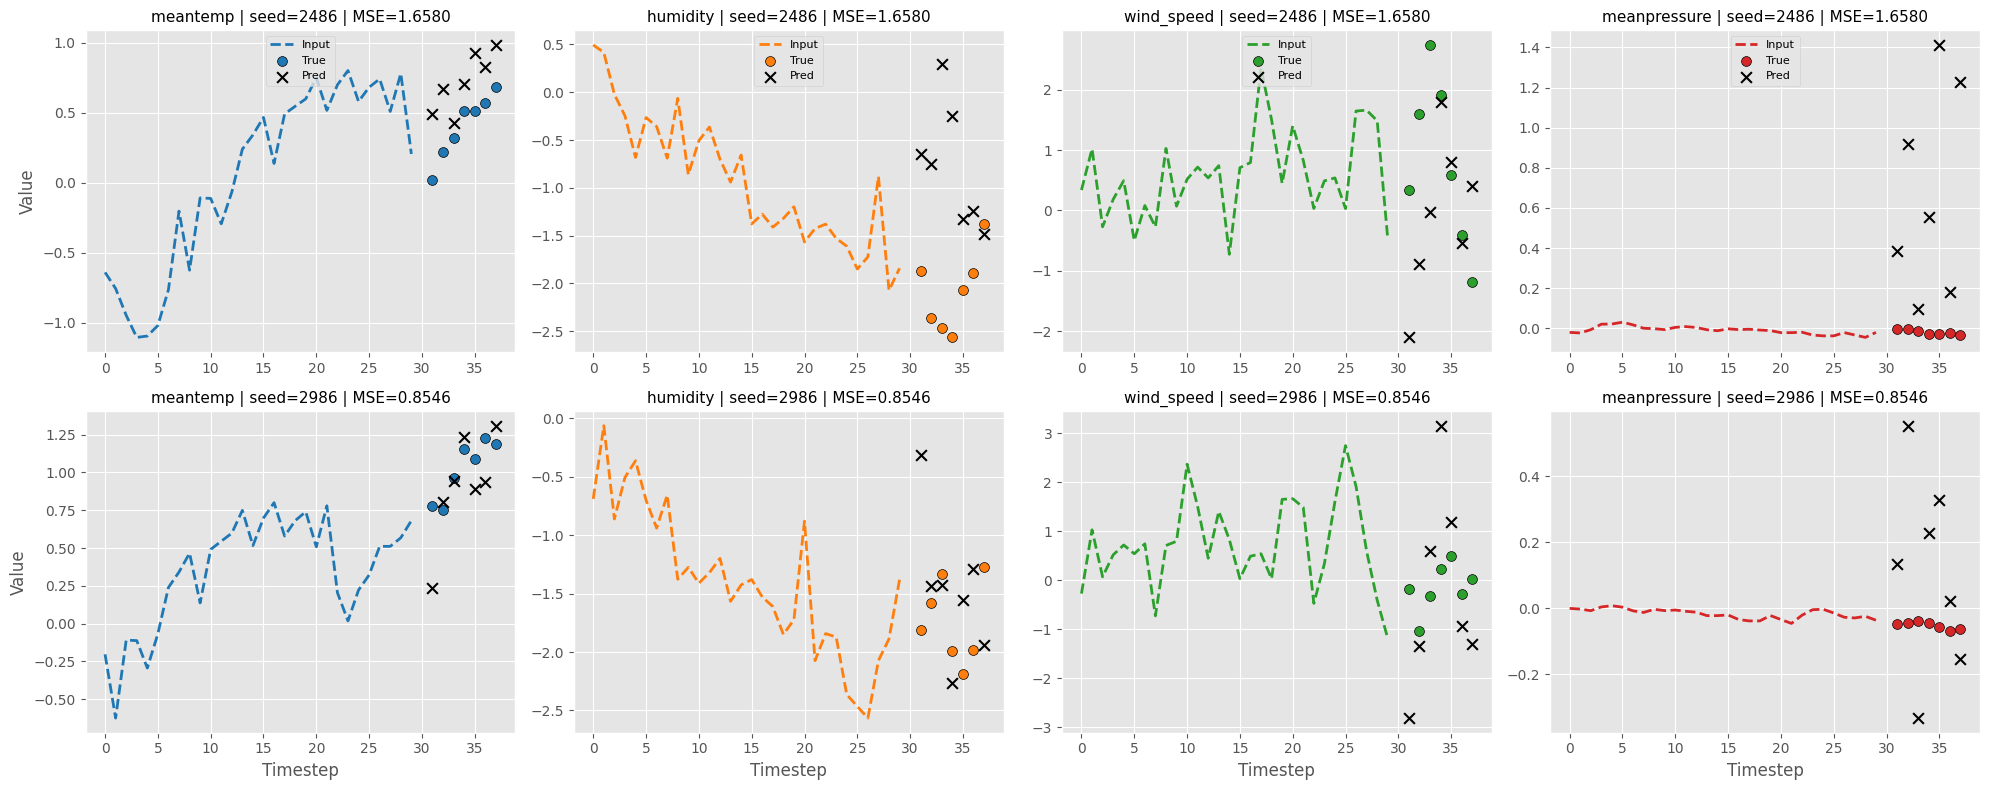

In [44]:
# Visualize
model_evaluation_and_visualizations(seq2seq_model, test_dataloader, device)